In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/usr/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
import resnet50; reload (resnet50)
from resnet50 import Resnet50

In [3]:
from keras import backend
backend.set_image_dim_ordering('th')

In [4]:
path = '/input/dogscats/'
batch_size=32 # batch_size=64 cause memory error on pre-computed data, if I use fit_generator, it will be fine.

In [8]:
test_batches = get_batches(path+'test1', gen=image.ImageDataGenerator(), batch_size=batch_size, shuffle=False, class_mode=None)

Found 0 images belonging to 0 classes.


In [5]:
%mkdir -p test/unknown
%cd /input/dogscats/test1
%cp *.jpg /output/test/unknown

/input/dogscats/test1


In [9]:
test_batches = get_batches('/output/test', gen=image.ImageDataGenerator(), batch_size=batch_size, shuffle=False, class_mode=None)

Found 12500 images belonging to 1 classes.


In [17]:
%cd /output

/output


In [10]:
res50 = Resnet50(include_top=False).model

/usr/local/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [11]:
# ImageDataGenerator to generate slightly different imgs.
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, horizontal_flip=True,
                                 shear_range=0.1, channel_shift_range=30, width_shift_range=0.1)

# Set to larger image where default is (224,224)
target_size=(224,224)

#get_batches (suffle=False)
batches = get_batches(path+'train', gen=image.ImageDataGenerator(), batch_size=batch_size, target_size=target_size, shuffle=False)
da_batches = get_batches(path+'train', gen_t, batch_size=batch_size, target_size=target_size, shuffle=False)
val_batches = get_batches(path+'valid', gen=image.ImageDataGenerator(), batch_size=batch_size, target_size=target_size, shuffle=False)
#test_batches = get_batches(path+'test', gen=image.ImageDataGenerator(), batch_size=batch_size, shuffle=False, class_mode=None)

Found 23000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
#(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)
val_classes = val_batches.classes
trn_classes_wo_da = batches.classes
trn_classes = da_batches.classes
val_labels = to_categorical(val_batches.classes) # onehot
trn_labels_wo_da = to_categorical(batches.classes) # onehot
trn_labels = to_categorical(da_batches.classes) # onehot
#test_filenames = test_batches.filenames

In [13]:
filenames = batches.filenames
val_filenames = val_batches.filenames

In [14]:
# Pre-compute output of ResNet Blocks
val_features = res50.predict_generator(val_batches, val_batches.nb_sample)
print ('val_features complete.')
trn_features_wo_da = res50.predict_generator(batches, batches.nb_sample) # trn_features w/o data augmentation
print ('trn_featutes_wo_da complete.')

val_features complete.
trn_featutes_wo_da complete.


In [99]:
test_features = res50.predict_generator(test_batches, test_batches.nb_sample)
print ('test_featutes complete.')

test_featutes complete.


In [18]:
save_array('trn_features_wo_da.dat', trn_features_wo_da)
save_array('trn_classes_wo_da.dat',trn_classes_wo_da)
save_array('trn_labels_wo_da.dat',trn_labels_wo_da)
save_array('val_features.dat', val_features)
save_array('val_classes.dat',val_classes)
save_array('val_labels.dat',val_labels)

In [100]:
save_array('test_features.dat', test_features)

# Res50 with Bottleneck Fully-connected Layers#

In [32]:
def get_fc_layers(p):
    return [
        MaxPooling2D(input_shape=res50.layers[-1].output_shape[1:]),
        BatchNormalization(axis=1),
        Dropout(p/4),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(64, activation='relu'), #bneck here
        BatchNormalization(),
        Dropout(p/2),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(2, activation='softmax')
    ]     

In [38]:
p = 0.8 
model_res50_fc = Sequential(get_fc_layers(p))
model_res50_fc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_7 (MaxPooling2D)    (None, 2048, 3, 3)    0           maxpooling2d_input_5[0][0]       
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 2048, 3, 3)    8192        maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
dropout_17 (Dropout)             (None, 2048, 3, 3)    0           batchnormalization_17[0][0]      
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 18432)         0           dropout_17[0][0]                 
___________________________________________________________________________________________

In [39]:
from keras.optimizers import Nadam
model_res50_fc.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

**Train on data without augmentation**

In [40]:
model_res50_fc.optimizer.lr = 1e-4
model_res50_fc.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 16s - loss: 0.2732 - acc: 0.9171 - val_loss: 0.0449 - val_acc: 0.9845

In [41]:
model_res50_fc.optimizer.lr = 1e-5
model_res50_fc.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=2, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 16s - loss: 0.1118 - acc: 0.9698 - val_loss: 0.0630 - val_acc: 0.9855

In [43]:
model_res50_fc.optimizer.lr = 1e-5
model_res50_fc.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=3, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 16s - loss: 0.0699 - acc: 0.9804 - val_loss: 0.0461 - val_acc: 0.9905

In [44]:
model_res50_fc.save_weights('model_res50_fc_bneck_1.h5')

In [45]:
model_res50_fc.optimizer.lr = 1e-6
model_res50_fc.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=3, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/3
23000/23000 [==============================] - 16s - loss: 0.0425 - acc: 0.9877 - val_loss: 0.0560 - val_acc: 0.9860

In [46]:
model_res50_fc.save_weights('model_res50_fc_bneck_2.h5')

In [47]:
trn_features = res50.predict_generator(da_batches, batches.nb_sample) # trn_features w/o data augmentation
print ('trn_featutes complete.')

trn_featutes complete.


In [48]:
save_array('trn_features.dat', trn_features)

**Train on augmented data**

In [49]:
model_res50_fc.optimizer.lr = 1e-4
model_res50_fc.fit(trn_features, trn_labels, nb_epoch=2, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 16s - loss: 0.1093 - acc: 0.9694 - val_loss: 0.0396 - val_acc: 0.9865

In [59]:
model_res50_fc.optimizer.lr = 1e-5
model_res50_fc.fit(trn_features, trn_labels, nb_epoch=2, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
23000/23000 [==============================] - 16s - loss: 0.0326 - acc: 0.9890 - val_loss: 0.0511 - val_acc: 0.9855

In [102]:
model_res50_fc.load_weights('model_res50_fc_bneck_3.h5')

# Res50 with Fully Convolutional Network#

    Ver 1: fully convolutional network
    Ver 2: fully convolutional network with dropout
    Ver 3: fully convolutional network with larger output size (for visualzation purpose later)

In [212]:
# Ver_3
def get_fconv_layers():
    return [
        BatchNormalization(axis=1, input_shape=res50.output_shape[1:]),
        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(256, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(2, 3, 3, border_mode='same', activation='relu'),
        GlobalAveragePooling2D(),
        Activation('softmax')        
    ]
"""
# Ver_1
def get_fconv_layers():
    return [
        BatchNormalization(axis=1, input_shape=res50.output_shape[1:]),
        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        AveragePooling2D(),
        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(2, 1, 1, border_mode='valid', activation='relu'),
        GlobalAveragePooling2D(),
        Activation('softmax')        
    ]

# Ver_2
p = 0.5
def get_fconv_layers():
    return [
        BatchNormalization(axis=1, input_shape=res50.output_shape[1:]),
        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        AveragePooling2D(),
        Dropout(p/2),
        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),
        BatchNormalization(axis=1),
        AveragePooling2D(),
        Dropout(p),
        Convolution2D(2, 1, 1, border_mode='valid', activation='relu'),
        GlobalAveragePooling2D(),
        Activation('softmax')        
    ]
"""

"\n# Ver_1\ndef get_fconv_layers():\n    return [\n        BatchNormalization(axis=1, input_shape=res50.output_shape[1:]),\n        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),\n        BatchNormalization(axis=1),\n        AveragePooling2D(),\n        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),\n        BatchNormalization(axis=1),\n        Convolution2D(2, 1, 1, border_mode='valid', activation='relu'),\n        GlobalAveragePooling2D(),\n        Activation('softmax')        \n    ]\n\n# Ver_2\np = 0.5\ndef get_fconv_layers():\n    return [\n        BatchNormalization(axis=1, input_shape=res50.output_shape[1:]),\n        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),\n        BatchNormalization(axis=1),\n        AveragePooling2D(),\n        Dropout(p/2),\n        Convolution2D(512, 3, 3, border_mode='same', activation='relu'),\n        BatchNormalization(axis=1),\n        AveragePooling2D(),\n        Dropout(p),\n        Convolu

In [213]:
model_res50_fconv = Sequential(get_fconv_layers())
model_res50_fconv.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

**Train on data without augmentation**

In [214]:
model_res50_fconv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_61 (BatchNorm (None, 2048, 7, 7)    8192        batchnormalization_input_13[0][0]
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (None, 512, 7, 7)     9437696     batchnormalization_61[0][0]      
____________________________________________________________________________________________________
batchnormalization_62 (BatchNorm (None, 512, 7, 7)     2048        convolution2d_41[0][0]           
____________________________________________________________________________________________________
convolution2d_42 (Convolution2D) (None, 256, 7, 7)     1179904     batchnormalization_62[0][0]      
___________________________________________________________________________________________

In [141]:
model_res50_fconv.optimizer.lr = 1e-4
model_res50_fconv.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 94s - loss: 0.0467 - acc: 0.9821 - val_loss: 0.0334 - val_acc: 0.9835

In [142]:
model_res50_fconv.optimizer.lr = 1e-5
model_res50_fconv.fit(trn_features_wo_da, trn_labels_wo_da, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 94s - loss: 0.0259 - acc: 0.9907 - val_loss: 0.0335 - val_acc: 0.9850

**Train on augmented data**

In [148]:
model_res50_fconv.optimizer.lr = 1e-4
model_res50_fconv.fit(trn_features, trn_labels, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 94s - loss: 0.0444 - acc: 0.9833 - val_loss: 0.0300 - val_acc: 0.9880

In [149]:
model_res50_fconv.optimizer.lr = 0
model_res50_fconv.fit(trn_features, trn_labels, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 94s - loss: 0.0260 - acc: 0.9904 - val_loss: 0.0408 - val_acc: 0.9875

In [150]:
model_res50_fconv.save_weights('model_res50_fconv_ver3_3.h5')

In [199]:
model_res50_fconv.load_weights('model_res50_fconv_1.h5')

In [215]:
model_res50_fconv.load_weights('model_res50_fconv_ver3_4.h5')

#Pseudo-labeling#

In [151]:
pseudo_preds = model_res50_fconv.predict(test_features, batch_size=batch_size)

In [155]:
model_res50_fconv.optimizer.lr = 1e-5

i_trn = 0
i_test = 0

# iterate through 800 mini-batch
num_iter = 600*2
# mini-batch size
size_trn = 44
size_test = 16
num_batch_per_epoch_trn = int(trn_features.shape[0]/size_trn)
num_batch_per_epoch_test = int(test_features.shape[0]/size_test)
index_trn = np.random.permutation(num_batch_per_epoch_trn)
index_test = np.random.permutation(num_batch_per_epoch_test)
for i in range(num_iter):
    i_trn = index_trn[i%num_batch_per_epoch_trn]
    i_test = index_test[i%num_batch_per_epoch_test]
    
    comb_features = np.concatenate((trn_features[(size_trn*i_trn):size_trn*(i_trn+1)],
                                   test_features[(size_test*i_test):size_test*(i_test+1)]),axis=0)
    comb_labels = np.concatenate((trn_labels[(size_trn*i_trn):size_trn*(i_trn+1)],
                                 pseudo_preds[(size_test*i_test):size_test*(i_test+1)]), axis=0)
    
    model_res50_fconv.train_on_batch(comb_features, comb_labels)
    
    if (i+1)%num_batch_per_epoch_trn == 0:
        index_trn = np.random.permutation(num_batch_per_epoch_trn)
    if (i+1)%num_batch_per_epoch_test == 0:
        index_test = np.random.permutation(num_batch_per_epoch_test)

In [156]:
model_res50_fconv.optimizer.lr = 1e-9
model_res50_fconv.fit(trn_features, trn_labels, nb_epoch=1, batch_size=batch_size, validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 95s - loss: 0.0337 - acc: 0.9867 - val_loss: 0.0390 - val_acc: 0.9840

In [121]:
model_res50_fc.load_weights('model_res50_fc_bneck_4.h5')

In [115]:
model_res50_fconv.load_weights('model_res50_fconv_ver2_2.h5')

In [135]:
model_res50_fconv.load_weights('model_res50_fconv_1.h5')

In [157]:
model_res50_fconv.save_weights('model_res50_fconv_ver3_4.h5')

# Visualize fconv_ver3

In [161]:
import cv2

In [188]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (224,224))

Calling backend function()

In [216]:
l = model_res50_fconv.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output) # l[-3] is the last conv layer

Visualize training data 2564

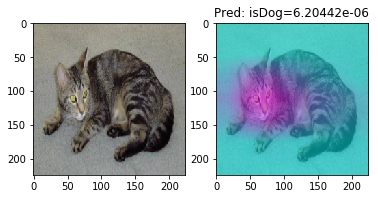

In [217]:
#path_predict_test = '/output/test/'+test_batches.filenames[2241]
path_predict_test = path+'train/'+batches.filenames[2564]

predict_test_img = misc.imread(path_predict_test)
predict_test_img = cv2.resize(predict_test_img,(224,224))
predict_test_img = np.rollaxis(predict_test_img,2,0)
predict_test_img = np.expand_dims(predict_test_img, 0)

temp = misc.imread(path_predict_test)
temp = cv2.resize(temp,(224,224))

pred_test_features = res50.predict(predict_test_img)
pred_test = model_res50_fconv.predict(pred_test_features)

plt.subplot(121)
plt.imshow(temp)
plt.subplot(122)
plt.title('Pred: isDog='+str(pred_test[0][1]))
plt.imshow(temp)
plt.imshow(get_cm2(pred_test_features, 0), cmap="cool", alpha=0.5)

Visualize test data 8741 (weird activation at top-right)

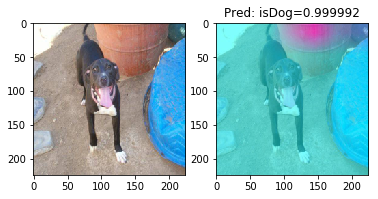

In [221]:
path_predict_test = '/output/test/'+test_batches.filenames[8741]
#path_predict_test = path+'train/'+batches.filenames[2564]

predict_test_img = misc.imread(path_predict_test)
predict_test_img = cv2.resize(predict_test_img,(224,224))
predict_test_img = np.rollaxis(predict_test_img,2,0)
predict_test_img = np.expand_dims(predict_test_img, 0)

temp = misc.imread(path_predict_test)
temp = cv2.resize(temp,(224,224))

pred_test_features = res50.predict(predict_test_img)
pred_test =  model_res50_fconv.predict(pred_test_features)

plt.subplot(121)
plt.imshow(temp)
plt.subplot(122)
plt.title('Pred: isDog='+str(pred_test[0][1]))
plt.imshow(temp)
plt.imshow(get_cm2(pred_test_features, 0), cmap="cool", alpha=0.5)

# Submission#

In [158]:
preds = model_res50_fconv.predict(test_features, batch_size = batch_size)

In [159]:
isdog = preds[:,1]
#isdog = isdog.clip(min=0.02, max=0.98)
filenames = test_batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])
subm = np.stack([ids,isdog], axis=1)

submission_file_name = 'subm_res50_fconv_ver3.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')